# Supriselib and Custom Recommender (Content-based) on MovieLens data
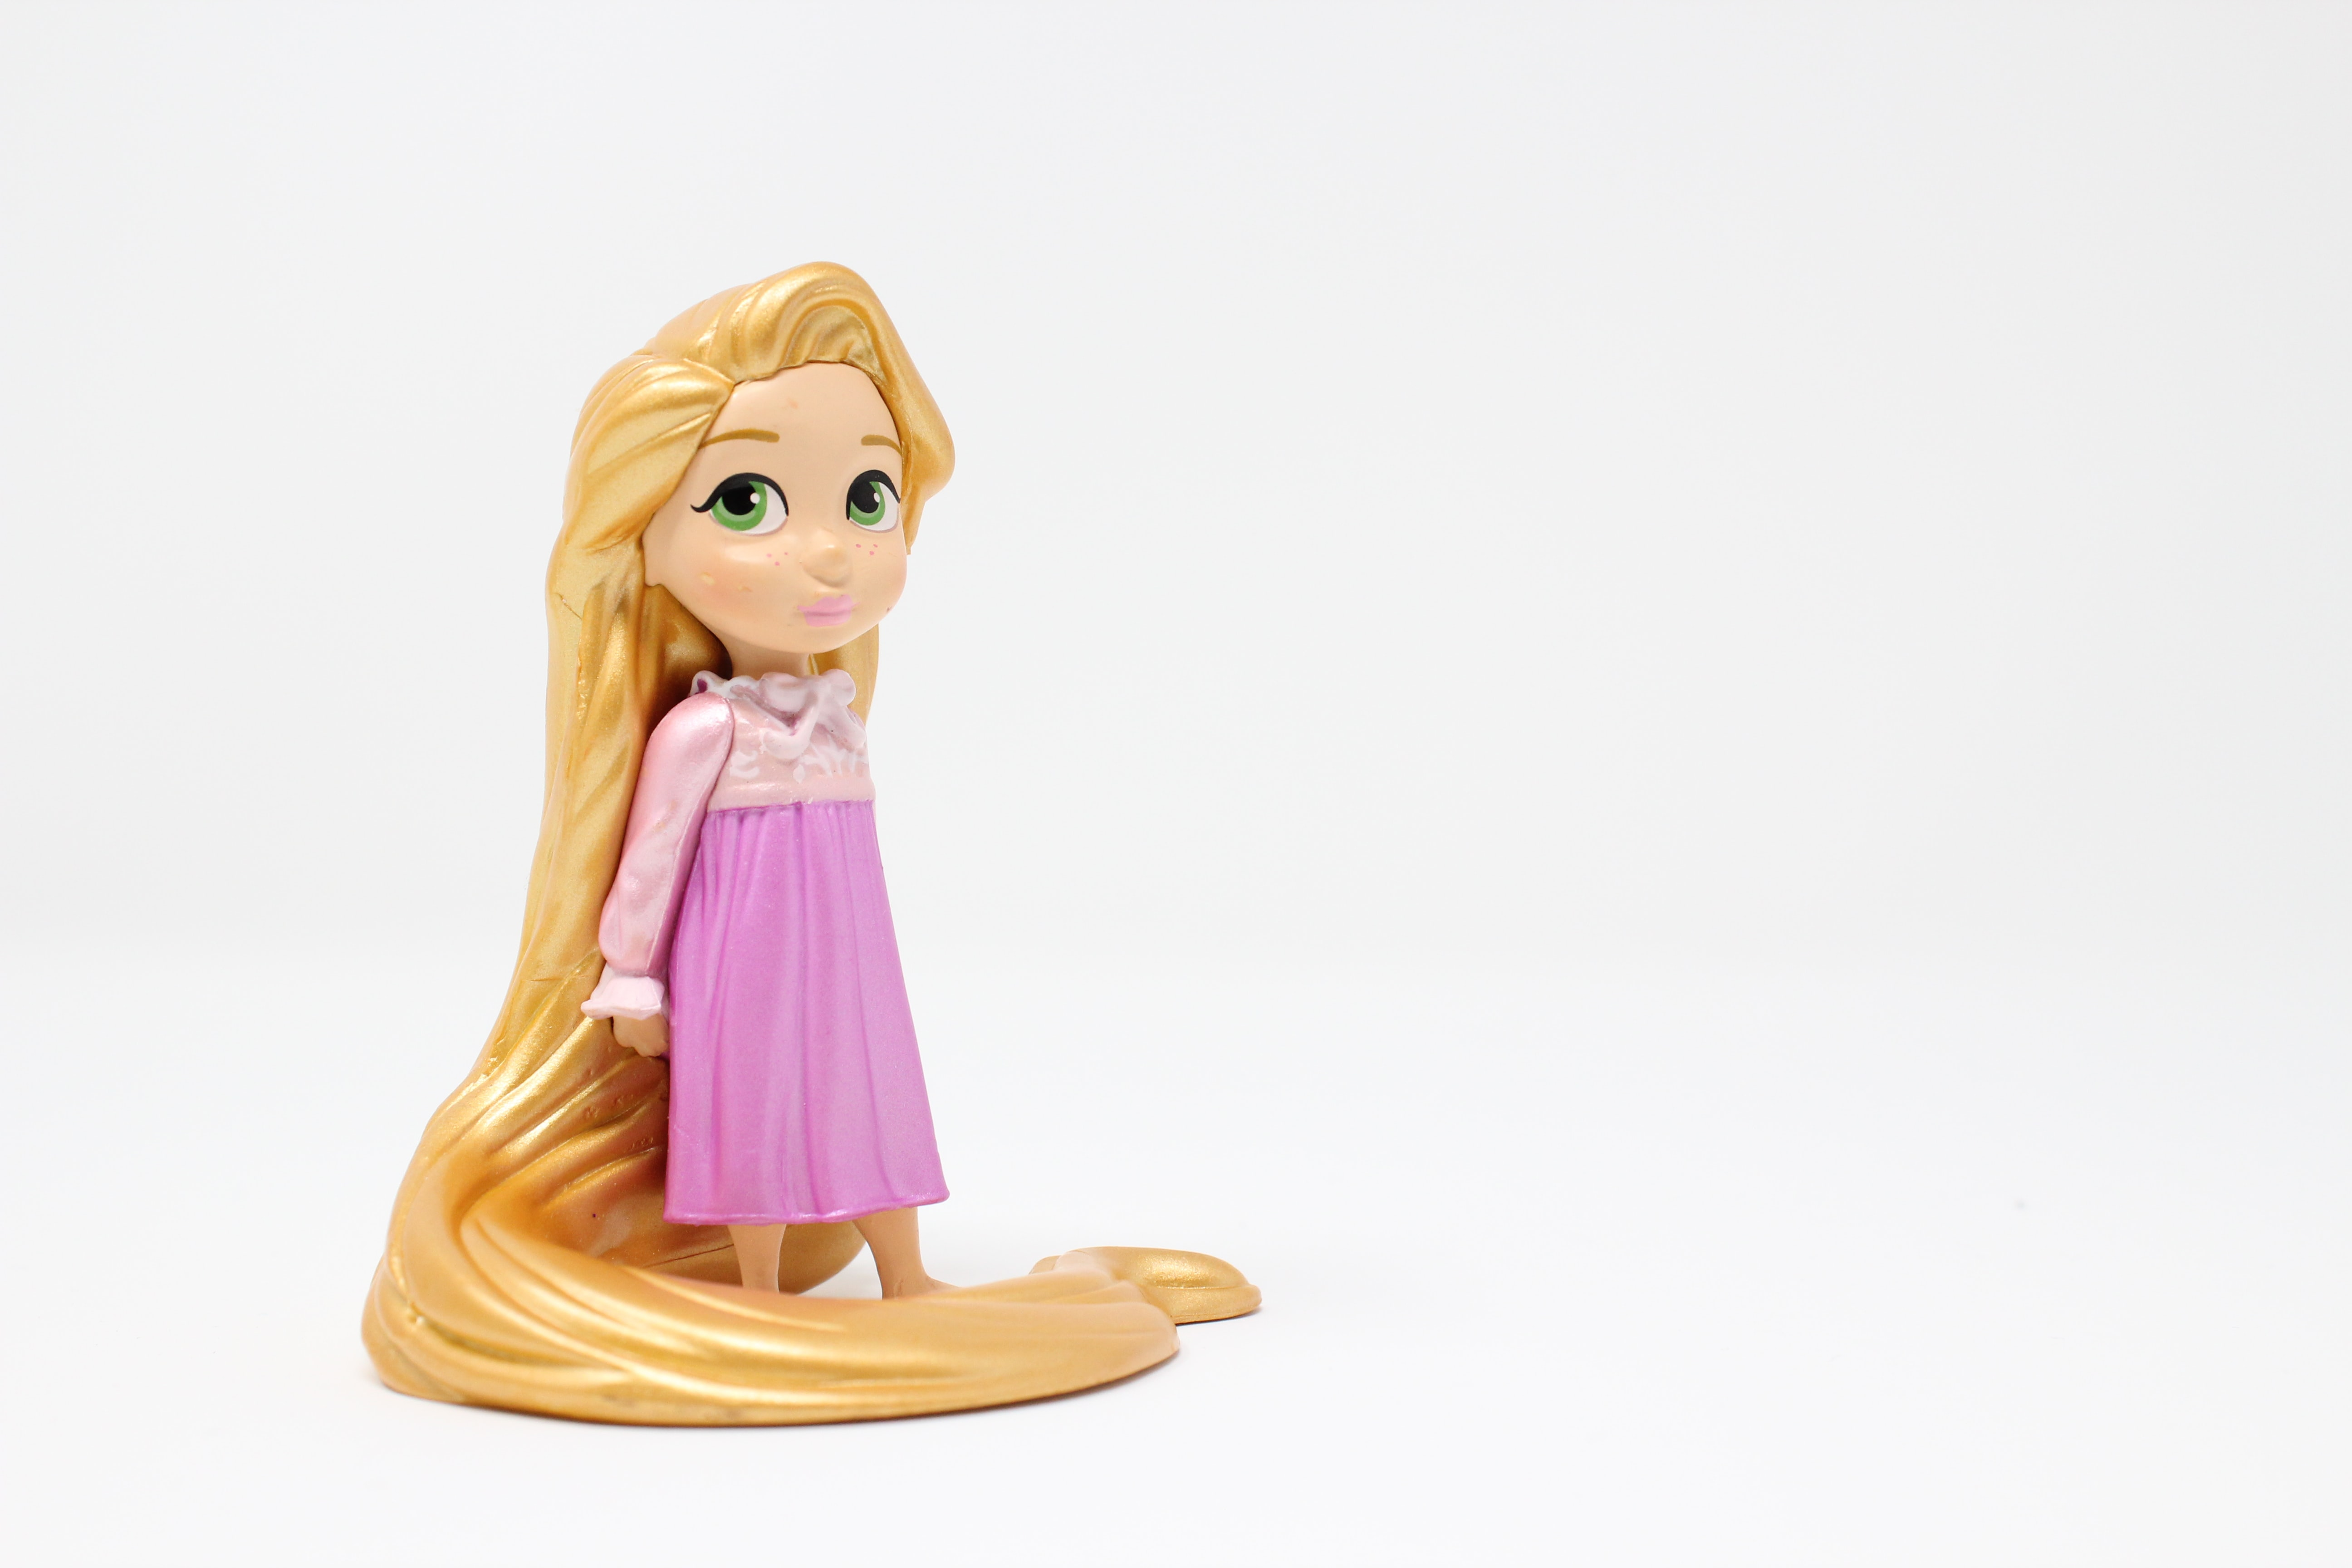

In [63]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re
import math
import heapq
from tqdm import tqdm

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import LeaveOneOut
from surprise.model_selection import train_test_split
from surprise import KNNBaseline
from RecommenderMetrics import RecommenderMetrics

# If the prediction is impossible
from surprise import PredictionImpossible

from surprise import AlgoBase

In [64]:
movies_path = 'ml-latest-small/movies.csv'
movies_DF = pd.read_csv(movies_path) 
print(movies_DF.shape)
movies_DF.head()

(9125, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [65]:
ratings_path = 'ml-latest-small/ratings.csv'
ratings_DF = pd.read_csv(ratings_path)
ratings_DF.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [66]:
def load_dataset():
    # Define file path
    movies_path = 'ml-latest-small/movies.csv'
    links_path = 'ml-latest-small/links.csv'
    ratings_path = 'ml-latest-small/ratings.csv'
    
    # Read file into Dataframe
    movies_DF = pd.read_csv(movies_path)    
    links_DF = pd.read_csv(links_path)     
    ratings_DF = pd.read_csv(ratings_path)
    
    ratings_DF['movieId'] = ratings_DF['movieId'].astype(str)
    ratings_DF['userId'] = ratings_DF['userId'].astype(str)
    # Reader class is used to parse a file containing ratings
    # The structure is as follows
    # user ; item ; rating ; [timestamp]
    # Dataset.load_from_file - loads a custom file
    reader = Reader(rating_scale=(1, 5))
    rating_dataset = Dataset.load_from_df(ratings_DF[['userId','movieId','rating']], reader=reader)
    
    return rating_dataset

In [67]:
def get_popularity_rank():
    popular_DF = pd.DataFrame(ratings_DF['movieId'].value_counts())
    popular_DF.columns = ['count']
    popular_DF.sort_values('count',ascending = False)
    rank = [x for x in range(len(popular_DF))]
    popular_DF['rank'] = rank
    popular_DF.drop('count',axis = 1,inplace = True)
    return popular_DF.to_dict('dict')['rank']
#get_popularity_rank()

In [84]:
def anti_test_set(test_subject,train_set):
    anti_test_set = []
    avg_rating = train_set.global_mean
    u = train_set.to_inner_uid(str(test_subject))
    
    # j is item inner id
    # user_items is a list of inner item ids that test subject u rated
    user_items = set([j for (j, _) in train_set.ur[u]])
    
    # anti-test set - (test subject, item that is not already rated by test subject, global mean)
    for i in train_set.all_items():
        if i not in user_items:
            anti_test_set.append((train_set.to_raw_uid(u),train_set.to_raw_iid(i),avg_rating))
            
    return anti_test_set

In [69]:
max_id = 0
movie_genre = defaultdict(list)
genre_id_dict = defaultdict(int)

def extract_genres(cols):
    global max_id
    genre_list = []
    genres = cols[1].split('|')
    for genre in genres:
        if genre not in genre_id_dict:
            genre_id_dict[genre] = max_id
            max_id+=1
        genre_list.append(genre_id_dict[genre])
    movie_genre[cols[0]] = genre_list 

In [82]:
def get_genres():
    movies_DF[['movieId','genres']].apply(extract_genres, axis = 1)
    
    # Convert integer-encoded genre lists to bitfields that we can treat as vectors
    genre_no = len(genre_id_dict)
    for (movie_id, genre_id_list) in movie_genre.items():
        bitfield = [0] * max_id
        for genre_id in genre_id_list:
            bitfield[genre_id] = 1
        movie_genre[movie_id] = bitfield 
    
    return movie_genre
#get_genres()

In [71]:
movie_years = defaultdict(int)
def extract_years(cols):
    p = re.compile(r"(?:\((\d{4})\))?\s*$")
    m = p.search(cols[1]).group(1)
    if m:
        movie_years[cols[0]] = int(m)

In [72]:
def get_years():
    movies_DF[['movieId','title']].apply(extract_years, axis = 1) 
    return movie_years 

In [73]:
class Content_Based_KNN(AlgoBase):

    def __init__(self, k = 40, sim_options = {}):
        # Always call base method before doing anything.
        AlgoBase.__init__(self)
        self.k = k
        
    # Write logic that can be calculated independent of the user or item in questions
    def fit(self, trainset):
        # Here again: call base method before doing anything.
        AlgoBase.fit(self, trainset)
        genres = get_genres()
        years = get_years() 
        
        # compute similarity matrix 2x2 | item x item
        self.similarities = np.zeros((self.trainset.n_items, self.trainset.n_items))
        
        # calculate pairwise similarity for all existing movies
        for movie_a in tqdm(range(self.trainset.n_items)):
        #for movie_a in range(100):
           # if (movie_a% 100 == 0):
                # print(movie_a, " of ", self.trainset.n_items)
            for movie_b in range(movie_a+1,self.trainset.n_items):
                movie_a_id = int(self.trainset.to_raw_iid(movie_a))
                movie_b_id = int(self.trainset.to_raw_iid(movie_b))
                genre_similarity = self.compute_genre_similarity(movie_a_id, movie_b_id, genres)
                year_similarity = self.compute_year_similarity(movie_a_id, movie_b_id, years)
                self.similarities[movie_a, movie_b] =  genre_similarity * year_similarity
                self.similarities[movie_b, movie_a] = self.similarities[movie_a, movie_b]
                
        print("...done.")
        return self
    
    def compute_genre_similarity(self, movie1, movie2, genres):
        # Cosine Similarity
        genres1 = genres[movie1]
        genres2 = genres[movie2]
        sumxx, sumxy, sumyy = 0, 0, 0
        for i in range(len(genres1)):
            x = genres1[i]
            y = genres2[i]
            sumxx += x * x
            sumyy += y * y
            sumxy += x * y
        
        return sumxy/math.sqrt(sumxx*sumyy)
    
    def compute_year_similarity(self, movie1, movie2, years):
        diff = abs(years[movie1] - years[movie2])
        sim = math.exp(-diff / 10.0)
        return sim
    
    def estimate(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('User and/or item is unkown.')
        """
        k-nearest-neighbors:
            a.	Compute the similarity score between the movie you want to predict and all the movies the user rated
            b.	Select k movies with the highest similarity to the movie we are making the prediction for.
            c.	Take weighted average of the similarity scores, weighing them by the rating the user gave them
        """
        # a.
        # Get all movies the user has rated 
        neighbors = []
        for rating in self.trainset.ur[u]:
            # Fetch similarity between predictant movie and movies user rated
            genre_similarity = self.similarities[i,rating[0]]
            # Append similarity score and rating
            neighbors.append( (genre_similarity, rating[1]))
        
        # b.
        # Extract the top-K most-similar ratings
        k_neighbors = heapq.nlargest(self.k, neighbors, key=lambda t: t[0])
        
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('User and/or item is unkown.')
        
        # c.
        # Compute average sim score of K neighbors weighted by user ratings
        sim_total = weighted_sum = 0
        for (sim_score, rating) in k_neighbors:
            if (sim_score > 0):
                sim_total += sim_score
                weighted_sum += sim_score * rating
            
        if (sim_total == 0):
            raise PredictionImpossible('No neighbors')

        predicted_rating = weighted_sum / sim_total

        return predicted_rating

In [74]:
def get_movie_id_name():
    return movies_DF.set_index('movieId').to_dict('dict')['title']

In [76]:
# Pick an arbitrary test subject
test_subject = 85
data = load_dataset()
movie_id_name_dict = get_movie_id_name()
algo = Content_Based_KNN()
print("Done...")

Done...


In [77]:
movies_of_user_loves = ratings_DF[(ratings_DF['userId'] == test_subject) & (ratings_DF['rating'] > 4.0)][['movieId','rating']]
movies_of_user_loves.sort_values(by = ['rating'],ascending = False,inplace = True)
movies_of_user_loves  = movies_of_user_loves['movieId'].tolist()

print('Movies user likes.....\n')
for movie in movies_of_user_loves:
    print(movie_id_name_dict[movie])

Movies user likes.....

Jumanji (1995)
Clear and Present Danger (1994)
Mission: Impossible (1996)
Terminator 2: Judgment Day (1991)
Jurassic Park (1993)
Fugitive, The (1993)
True Lies (1994)
Speed (1994)
Star Trek: Generations (1994)
GoldenEye (1995)
Shawshank Redemption, The (1994)
Stargate (1994)
Pulp Fiction (1994)
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)
Jerky Boys, The (1995)
Braveheart (1995)
Rock, The (1996)


In [78]:
movies_of_user_hates = ratings_DF[(ratings_DF['userId'] == test_subject) & (ratings_DF['rating'] < 3.0)][['movieId','rating']]
movies_of_user_hates.sort_values(by = ['rating'],ascending = False,inplace = True)
movies_of_user_hates  = movies_of_user_hates['movieId'].tolist()

print('Movies user hates.....\n')
for movie in movies_of_user_hates:
    print(movie_id_name_dict[movie])

Movies user hates.....

Grumpier Old Men (1995)
Snow White and the Seven Dwarfs (1937)
Lord of Illusions (1995)
Dolores Claiborne (1995)
Schindler's List (1993)
Philadelphia (1993)
Miracle on 34th Street (1994)
Mortal Kombat (1995)
Naked Gun 33 1/3: The Final Insult (1994)
Wes Craven's New Nightmare (Nightmare on Elm Street Part 7: Freddy's Finale, A) (1994)
Operation Dumbo Drop (1995)
Nightmare Before Christmas, The (1993)
Super Mario Bros. (1993)
Beverly Hills Cop III (1994)
Richie Rich (1994)
Tank Girl (1995)
While You Were Sleeping (1995)
Poison Ivy II (1996)
Nell (1994)
Little Women (1994)
Heavenly Creatures (1994)
Prophecy, The (1995)
Mighty Morphin Power Rangers: The Movie (1995)
Casper (1995)
Postman, The (Postino, Il) (1994)
Oliver & Company (1988)


In [85]:
# For making Top N Recommendations
# --------------------------------
full_train_set = data.build_full_trainset()
anti_test_set_for_user  = anti_test_set(test_subject, full_train_set)

algo.fit(full_train_set)
predictions = algo.test(anti_test_set_for_user)

recommendations = []
print ("\nWe recommend:\n")
for user_id, movie_id, avg_rating, estimated_rating, _ in predictions:
    recommendations.append((int(movie_id), estimated_rating))

recommendations.sort(key=lambda x: x[1], reverse=True)

for ratings in recommendations[:10]:
    print(movies_DF[movies_DF['movieId']==ratings[0]]['title'].values[0])

100%|██████████| 9066/9066 [04:47<00:00, 31.57it/s] 


...done.

We recommend:

Presidio, The (1988)
Femme Nikita, La (Nikita) (1990)
Wyatt Earp (1994)
Shooter, The (1997)
Bad Girls (1994)
The Hateful Eight (2015)
True Grit (2010)
Open Range (2003)
Big Easy, The (1987)
Point Break (1991)


In [86]:
# For measuring accuracy
# -----------------------
train_set, test_set = train_test_split(data, test_size=.25, random_state=1)
algo.fit(train_set)
accuracy_predictions = algo.test(test_set)
print('RMSE: ',RecommenderMetrics.RMSE(accuracy_predictions))
print('MAE: ',RecommenderMetrics.MAE(accuracy_predictions))

100%|██████████| 8211/8211 [03:37<00:00, 37.78it/s] 


...done.
RMSE:  0.9375064084541399
MAE:  0.7263424771236011


In [87]:
# For measuring Hit Rate, Cumulative Hit Rate, Rating Hit Rate, Average Reciprocal Hit Rate
# ------------------------------------------------------------------------------------------
LOOCV = LeaveOneOut(n_splits=1, random_state=1)
for train, test in LOOCV.split(data):
    LOOCV_train = train
    LOOCV_test = test
    #print("TRAIN:", train, "TEST:", test)
algo.fit(LOOCV_train)
leave_one_out_predictions = algo.test(LOOCV_test)

# Anti-test set: The ratings are all the ratings that are not in the trainset, 
#i.e. all the ratings rui where the user u is known, 
#the item i is known, but the rating rui is not in the trainset.
LOOCV_anti_test_set = LOOCV_train.build_anti_testset()

# Build predictions for all ratings not in the training set
all_predictions_loocv = algo.test(LOOCV_anti_test_set)

n = 10

# Get top N Recommendations for each user to calculate HR, RHR,ARHR
top_n_predicted = RecommenderMetrics.GetTopN(all_predictions_loocv, n)
print(RecommenderMetrics.HitRate(top_n_predicted, leave_one_out_predictions))
print(RecommenderMetrics.CumulativeHitRate(top_n_predicted, leave_one_out_predictions))
print(RecommenderMetrics.AverageReciprocalHitRank(top_n_predicted, leave_one_out_predictions))

100%|██████████| 9053/9053 [04:37<00:00, 32.58it/s] 


...done.
0.0029806259314456036
0.0029806259314456036
0.0017032148179689163


In [89]:
# For measuring Coverage, Diversity and Novelty
# ----------------------------------------------

n = 10
full_train_set = data.build_full_trainset()
full_anti_test_set = full_train_set.build_anti_testset()
algo.fit(full_train_set)
all_predictions_full = algo.test(full_anti_test_set)
top_n_predicted = RecommenderMetrics.GetTopN(all_predictions_full, n)

# Coverage
print('Computing Coverage')
print("Coverage: ", RecommenderMetrics.UserCoverage(top_n_predicted , full_train_set.n_users, ratingThreshold=4.0))

# Diversity
# Get similarities
# Compute similarty matrix between items so we can measure diversity
sim_options = {'name': 'cosine', 'user_based': False}
sims_algo = KNNBaseline(sim_options=sim_options)
sims_algo.fit(full_train_set)
print('Computing Diversity')
print('Diversity: ',RecommenderMetrics.Diversity(top_n_predicted, sims_algo))

# Novelty
# Get popularity ranking
print('Novelty:',RecommenderMetrics.Novelty(top_n_predicted,get_popularity_rank()))

100%|██████████| 9066/9066 [04:31<00:00, 33.36it/s] 


...done.
Computing Coverage
Coverage:  0.9284649776453056
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing Diversity
Computing the cosine similarity matrix...
Done computing similarity matrix.
Diversity:  0.5700036080106995
Novelty: 4651.525758069775
